In [16]:
import data_engine
from feature_extractor.core import load_extractor_config,extract_feature 
from framework import extract_stock_feature,load_extracted_feature 
import analyzer
from analyzer.core import load_analyzer_config,prepare_data,split_cv,get_X,get_Y
from analyzer.target import tri_trend
from analyzer.metrics import showMetrics
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np


In [2]:
data_config_file="configs/data_config/300.json"
feature_config_file="configs/feature_config/test_config.json"
analyzer_config_file="configs/analyzer_config/simple.cfg"

In [3]:
analyzer_config = load_analyzer_config(analyzer_config_file)
extract_stock_feature(data_config_file,feature_config_file,force=False)
df = load_extracted_feature(data_config_file,feature_config_file)

KeysView(<configparser.ConfigParser object at 0x7f17243af518>)
[DEFAULT]
[data]
train_start = "2005-01-01"
train_end = "2017-12-31"
cv_date = "2018-01-01"
validate_start = "2018-01-01"
validate_end = "2018-11-01"
[X]
exclude = 
[Y]
target = tri_trend
mp_extract_stock_feature start-2019-02-27 03:27:21.524627
['cache8.pkl', 'cache19.pkl', 'cache10.pkl', 'cache14.pkl', 'cache17.pkl', 'cache23.pkl', 'cache3.pkl', 'cache20.pkl', 'cache5.pkl', 'cache2.pkl', 'cache15.pkl', 'cache0.pkl', 'cache12.pkl', 'cache22.pkl', 'cache9.pkl', 'cache11.pkl', 'cache7.pkl', 'cache16.pkl', 'cache4.pkl', 'cache21.pkl', 'cache13.pkl', 'cache6.pkl', 'cache18.pkl', 'cache1.pkl']
dir is not empty
extract file path:/tmp/features/pool300_test_config_2004-01-01-2019-02-22 is not empty, wait 3s to check if the data is ok. You can remove the files in the directory,or pass argument force=True
create index feature


/home/wanw/stockAnalyze/feature_extractor/features/target.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[name] = (df.close - df['low'].rolling(N).min())/df.close*100
/home/wanw/stockAnalyze/feature_extractor/features/target.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[name] = np.where(df[name]<0,0,df[name])
/home/wanw/stockAnalyze/feature_extractor/features/target.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [5]:
df = tri_trend(df,{})
print(df.describe())
print(df.columns)

                open          close           high            low  \
count  580136.000000  580136.000000  580136.000000  580136.000000   
mean        9.641975       9.659650       9.873895       9.439039   
std        12.289548      12.321581      12.632377      12.006005   
min         0.213000       0.215000       0.223000       0.211000   
25%         3.369000       3.372000       3.440000       3.302000   
50%         6.162000       6.174000       6.300000       6.041000   
75%        11.557000      11.576000      11.830000      11.316000   
max       355.422000     360.565000     364.138000     345.738000   

             volume        PDelta1        PDelta5       PDelta10  \
count  5.801360e+05  579837.000000  578649.000000  577173.000000   
mean   1.408553e+05       0.082608       0.440819       0.858905   
std    4.656629e+05       3.536226       8.626121      12.644253   
min    1.000000e+00     -38.818845     -44.456359     -65.131490   
25%    1.953913e+04      -1.504597    

In [6]:
df = prepare_data(df,analyzer_config)
train_df,test_df = split_cv(df,analyzer_config)
print('train:{},test:{}'.format(train_df.shape,test_df.shape))
train_X = get_X(train_df,analyzer_config)
train_Y = get_Y(train_df,analyzer_config)

Index(['date', 'open', 'close', 'high', 'low', 'volume', 'code', 'PDelta1',
       'PDelta5', 'PDelta10',
       ...
       'VRI5_399006', 'VRI10_399006', 'VRI20_399006', 'Y_mdw5_399006',
       'Y_mdw10_399006', 'Y_mdw20_399006', 'Y_pma5_399006', 'Y_pma10_399006',
       'Y_pma20_399006', 'Y_tri_trend'],
      dtype='object', length=133)
0         2008-01-16
1         2008-01-16
2         2008-01-16
3         2008-01-16
4         2008-01-16
5         2008-01-16
6         2008-01-16
7         2008-01-16
8         2008-01-16
9         2008-01-16
10        2008-01-16
11        2008-01-16
12        2008-01-16
13        2008-01-16
14        2008-01-16
15        2008-01-16
16        2008-01-16
17        2008-01-16
18        2008-01-16
19        2008-01-16
20        2008-01-16
21        2008-01-16
22        2008-01-16
23        2008-01-16
24        2008-01-16
25        2008-01-16
26        2008-01-16
27        2008-01-16
28        2008-01-16
29        2008-01-16
             ...    
580107  

In [13]:
params = {"booster": "gbtree",
          'max_depth':4, 
          'eta':0.3, 
          'silent':1, 
          'objective':'multi:softmax',
          'num_class':3 ,
          "subsample":0.5,
          "colsample_bytree":0.5,
          "learning_rate":0.1,
          "n_estimators":140,
          "gamma":0}
num_round = 100 
    
dtrain = xgb.DMatrix( train_X,train_Y)
model = xgb.train(params.items(), dtrain, num_round)

<Figure size 1296x1440 with 0 Axes>

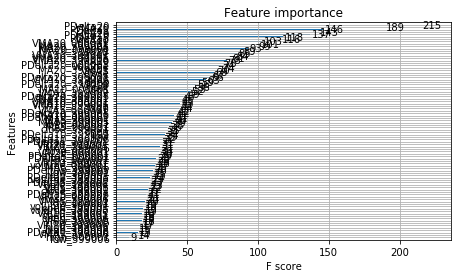

In [12]:
plt.figure(figsize=(18,20))
xgb.plot_importance(model)
plt.show()

In [14]:
print('train loss:')
ytrain = model.predict(dtrain)
showMetrics(train_Y,ytrain)

train loss:
accuracy:0.641829 precision:0.675139 recall:0.559879 f1:0.574912
class precision
[0.73167891 0.59641759 0.69731989]
class recall
[0.593921   0.8288813  0.25683462]
class f1
[0.65564197 0.69369224 0.37540228]


In [17]:
print('test loss:')
test_X = get_X(test_df,analyzer_config)
test_Y = get_Y(test_df,analyzer_config)
dtest= xgb.DMatrix( test_X)
ytest = model.predict(dtest)
print(ytest)
print(min(ytest))
print(np.array(list(test_Y)))
print(min(test_Y))
showMetrics(test_Y,ytest)

test loss:
[1. 1. 1. ... 1. 1. 0.]
0.0
[1 0 1 ... 0 1 0]
0
accuracy:0.412705 precision:0.547490 recall:0.347324 f1:0.226209
class precision
[0.78134557 0.40763607 0.45348837]
class recall
[0.02028663 0.9884981  0.03318584]
class f1
[0.03954649 0.57723318 0.06184586]
